In [1]:
# Imports
from utils import load_MNE, get_dataset, get_loaders, get_args, get_mne_info

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from types import SimpleNamespace
import mne
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import PredefinedSplit, GridSearchCV

In [2]:
def plot_spectrograms_for_epoch(epoch_spectrograms, freqs, times, channels_to_plot):
    """
    epoch_spectrograms: Spectrogram array for one epoch (shape: 62 channels x freq_bins x time_bins)
    freqs: Array of frequencies
    times: Array of time windows
    channels_to_plot: List of channel indices to plot
    """
    num_channels = len(channels_to_plot)
    
    fig, axs = plt.subplots(num_channels, 1, figsize=(10, 10))
    
    if num_channels == 1:
        axs = [axs]  # To handle single-channel case
    
    # Loop through channels to plot
    for i, channel_idx in enumerate(channels_to_plot):
        # Plot the spectrogram for the channel
        db_scale = epoch_spectrograms[channel_idx, :, :]
        print(db_scale.shape)
        axs[i].pcolormesh(times, freqs[freqs <= 100], db_scale, shading='gouraud')
        axs[i].set_title(f'Channel {channel_idx + 1}')
        axs[i].set_ylabel('Frequency [Hz]')
        axs[i].set_xlabel('Time [s]')
    
    plt.tight_layout()
    plt.show()

# plot_spectrograms_for_epoch(next(iter(loaders['train']))[0][0], loaders['train'].dataset.freqs, loaders['train'].dataset.times, [0, 1, 2, 60, 61])

# SVM for Subject 1
on spectrograms

In [3]:
# Create correct shape for SVM
def prepare_data(loader):
    X = []
    y = []
    
    for data, labels in tqdm(loader):
        # Flatten the data from (62, 21, 3) to (62 * 21 * 3)
        data = data.view(data.shape[0], -1).numpy()  # (batch_size, 62*21*3)
        labels = labels.numpy()  # Convert labels to numpy
        
        X.append(data)
        y.append(labels)
    
    # Concatenate all batches into single arrays
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    
    return X, y

In [4]:

for subject_idx in tqdm([-1]):
    
    # Splitting based on subject 1
    loaders = get_loaders(get_args(subject = subject_idx, 
                                dataset_dir='../../data/raw/EEG-ImageNet',
                                spectrogram_dir='../../data/processed/EEG-ImageNet',
                                spectrograms = True, 
                                split = [0.7, 0.15, 0.15],
                                nperseg = 100,
                                nfft = 128))

    # Print shapes of datasets
    #print(f"Train: {loaders['train'].dataset.data.shape} X {loaders['train'].dataset.data[0]['spectrograms'].shape}")
    #print(f"Val: {loaders['val'].dataset.data.shape} X {loaders['val'].dataset.data[0]['spectrograms'].shape}")
    #print(f"Test: {loaders['test'].dataset.data.shape} X {loaders['test'].dataset.data[0]['spectrograms'].shape}")

    if subject_idx == -1:
        subject_idx = 'all'
        
    # Prepare training, validation, and test data
    X_train, y_train = prepare_data(loaders['train'])
    X_val, y_val = prepare_data(loaders['val'])
    X_test, y_test = prepare_data(loaders['test'])

    print(f"Train: {X_train.shape}, {y_train.shape}")
    print(f"Val: {X_val.shape}, {y_val.shape}")
    print(f"Test: {X_test.shape}, {y_test.shape}")

    # Combine training and validation sets
    X_combined = np.vstack((X_train, X_val))  # Stack the data vertically
    y_combined = np.hstack((y_train, y_val))  # Stack the labels horizontally

    # Create an index that separates the training and validation sets
    # -1 for training samples, 0 for validation samples
    split_index = [-1] * len(X_train) + [0] * len(X_val)

    # Use PredefinedSplit to specify the training and validation data
    ps = PredefinedSplit(test_fold=split_index)

    # Define the parameter grid for the RBF kernel
    param_grid_rbf = {
        'C': [0.1, 1, 10, 100, 1000],  # Regularization parameter
        'gamma': [1e-3, 1e-2, 1e-1, 'scale', 'auto'],  # Kernel coefficient for RBF
    }

    # Define the parameter grid for the Linear kernel
    param_grid_linear = {
        'C': [0.1, 1, 10, 100, 1000],  # Regularization parameter for Linear kernel
    }

    # Instantiate the SVM models
    svm_rbf = SVC(kernel='rbf')
    svm_linear = SVC(kernel='linear')

    # Perform grid search for the RBF kernel
    grid_search_rbf = GridSearchCV(estimator=svm_rbf, param_grid=param_grid_rbf, cv=ps, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search_rbf.fit(X_train, y_train)  # Fit on your training data
    # Extract the results into a DataFrame and save to a CSV file
    results_df = pd.DataFrame(grid_search_rbf.cv_results_)
    results_df.to_csv(f'svm_rbf_grid_search_results_subject_{subject_idx}.csv', index=False)
    # Get the best parameters and scores
    print(f"Best parameters for RBF kernel: {grid_search_rbf.best_params_}")
    print(f"Best accuracy for RBF kernel: {grid_search_rbf.best_score_}")

    # Perform grid search for the Linear kernel
    grid_search_linear = GridSearchCV(estimator=svm_linear, param_grid=param_grid_linear, cv=ps, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search_linear.fit(X_train, y_train)  # Fit on your training data
    # Extract the results into a DataFrame and save to a CSV file
    results_df = pd.DataFrame(grid_search_linear.cv_results_)
    results_df.to_csv(f'svm_linear_grid_search_results_subject_{subject_idx}.csv', index=False)
    # Get the best parameters and scores
    print(f"Best parameters for Linear kernel: {grid_search_linear.best_params_}")
    print(f"Best accuracy for Linear kernel: {grid_search_linear.best_score_}")

    # Extract the results into a DataFrame and save to a CSV file
    results_df = pd.DataFrame(grid_search_rbf.cv_results_)
    results_df.to_csv(f'svm_rbf_grid_search_results_subject_{subject_idx}.csv', index=False)

    # Re-fit best model (depending on which kernel was best)
    best_svm = grid_search_rbf.best_estimator_ if grid_search_rbf.best_score_ > grid_search_linear.best_score_ else grid_search_linear.best_estimator_

    # Validate the retrained model on the validation data
    y_val_pred = best_svm.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f'Validation Accuracy with tuned SVM: {val_accuracy * 100:.2f}%')

    # Test the model on the test data
    y_test_pred = best_svm.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f'Test Accuracy with tuned SVM: {test_accuracy * 100:.2f}%')

    # save params
    with open(f'best_params_subject_{subject_idx}.txt', 'w') as f:
        f.write(f"Best parameters for RBF kernel: {grid_search_rbf.best_params_}\n")
        f.write(f"Best accuracy for RBF kernel: {grid_search_rbf.best_score_}\n")
        f.write(f"Best parameters for Linear kernel: {grid_search_linear.best_params_}\n")
        f.write(f"Best accuracy for Linear kernel: {grid_search_linear.best_score_}\n")
        f.write(f'Validation Accuracy with tuned SVM: {val_accuracy * 100:.2f}%\n')
        f.write(f'Test Accuracy with tuned SVM: {test_accuracy * 100:.2f}%')

    # Confusion matrix for test data
    conf_matrix = confusion_matrix(y_test, y_test_pred, normalize='true')

    # Get class labels (assuming label2class mapping is available)
    class_labels = [loaders['train'].dataset.label2class[label][0] for label in loaders['train'].dataset.idx2label.values()]

    # Plot the confusion matrix
    plt.figure(figsize=(20, 16))
    sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)

    # Rotate x-axis labels vertically and reduce font size
    plt.xticks(rotation=90, fontsize=12)  # Adjust fontsize for x-axis
    plt.yticks(rotation=0, fontsize=12)   # Adjust fontsize for y-axis

    plt.title(f'Subject {subject_idx} - Test Data - Acc: %.2f%%' % (test_accuracy * 100))
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.savefig(f'confusion_matrix_subject_{subject_idx}_optimized.png')

  0%|          | 0/1 [00:00<?, ?it/s]

Computing spectrograms..!
Not setting metadata
31950 matching events found
No baseline correction applied
0 projection items activated


100%|██████████| 31950/31950 [08:22<00:00, 63.62it/s]


Loading Training data


  0%|          | 0/1 [18:27<?, ?it/s]

Computing spectrograms..!


KeyError: 'eeg_data'

In [7]:
# Prepare training, validation, and test data
X_train, y_train = prepare_data(loaders['train'])
X_val, y_val = prepare_data(loaders['val'])
X_test, y_test = prepare_data(loaders['test'])

# combine Xs
X = np.concatenate([X_train, X_val, X_test], axis=0)

100%|██████████| 150/150 [00:03<00:00, 42.17it/s]


In [13]:
# Prepare training, validation, and test data
X_train, y_train = prepare_data(loaders['train'])
X_val, y_val = prepare_data(loaders['val'])
X_test, y_test = prepare_data(loaders['test'])

# combine Xs
X = np.concatenate([X_train, X_val, X_test], axis=0)
y = np.concatenate([y_train, y_val, y_test], axis=0)

In [14]:
y.shape

(31950,)

In [9]:
subjects = []
for loader in loaders.values():
    subs = [loader.dataset.data[idx]['subject'] for idx in range(len(loader.dataset.data))]
    subjects.extend(subs)

In [11]:
subjects.__len__()

31950

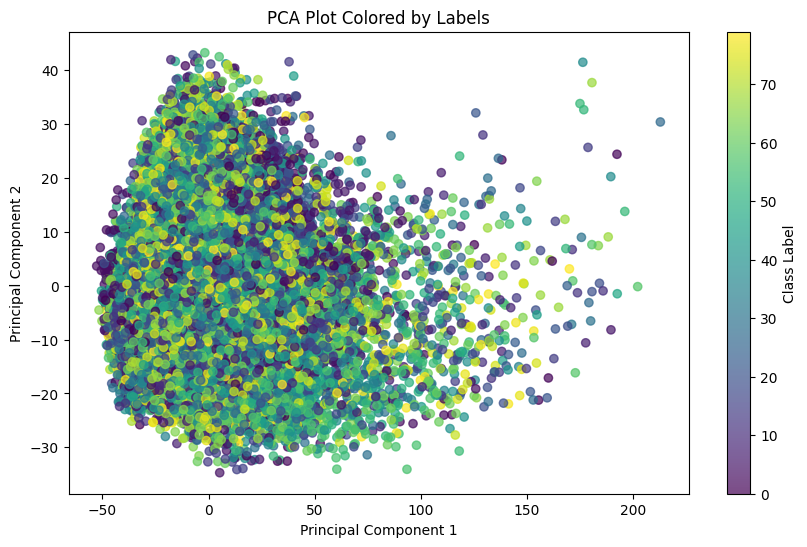

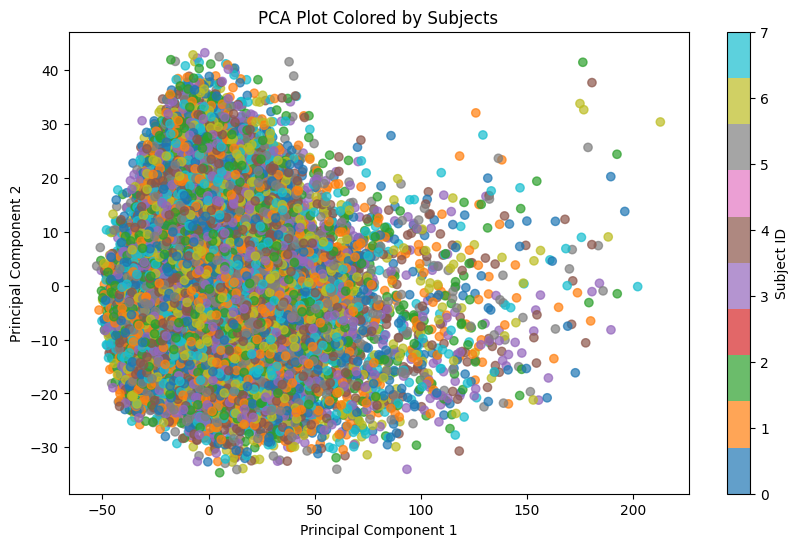

In [15]:
def plot_PCA(args, loaders, n_components=2):

    # Prepare training, validation, and test data
    X_train, y_train = prepare_data(loaders['train'])
    X_val, y_val = prepare_data(loaders['val'])
    X_test, y_test = prepare_data(loaders['test'])

    # combine Xs
    X = np.concatenate([X_train, X_val, X_test], axis=0)
    y = np.concatenate([y_train, y_val, y_test], axis=0)

    subjects = []
    for loader in loaders.values():
        subs = [loader.dataset.data[idx]['subject'] for idx in range(len(loader.dataset.data))]
        subjects.extend(subs)

    # Plot PCA with n_components (2 or 3) and save the plots within 'args.figure_dir/PCA' folder
    # also save explained variance plot

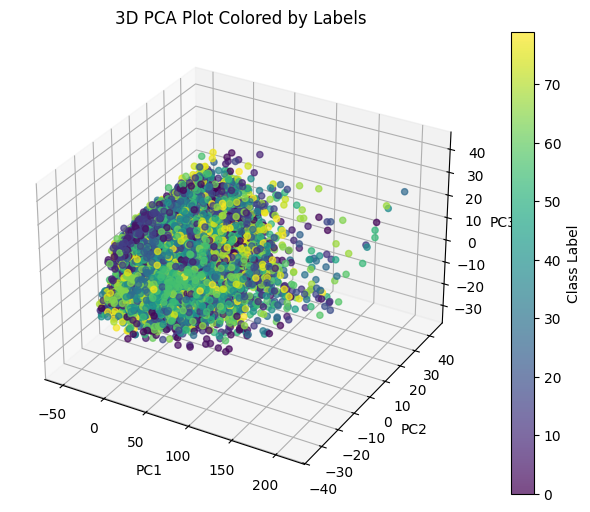

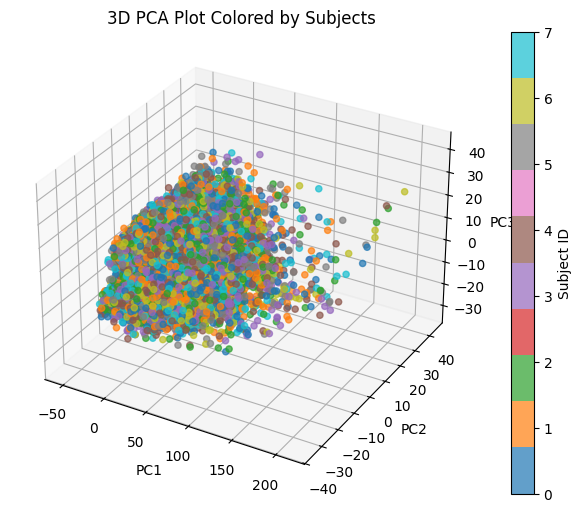

In [16]:
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA with 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# 3D Plot colored by labels
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', alpha=0.7)
ax.set_title('3D PCA Plot Colored by Labels')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
fig.colorbar(scatter, label='Class Label')
plt.savefig('../../figures/analysis/EEG-ImageNet/PCA/3D_PCA_plot_colored_by_labels.png')

# 3D Plot colored by subjects
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=subjects, cmap='tab10', alpha=0.7)
ax.set_title('3D PCA Plot Colored by Subjects')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
fig.colorbar(scatter, label='Subject ID')
plt.savefig('../../figures/analysis/EEG-ImageNet/PCA/3D_PCA_plot_colored_by_subjects.png')
